In [1]:
import openmc
import openmc.deplete # will be needed for depletion analysis eventually
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Create the assembly-cell model

### Materials

In [2]:
# materials

NpO2 = openmc.Material();
NpO2.add_nuclide('Np237',1);
NpO2.add_nuclide('Pu238',1e-14); #add a trace amount of Pu-238 so I can add a Pu-238 tally in the target from the begining.
NpO2.add_nuclide('Np238',1e-14); # ditto...
NpO2.add_element('O',2);
NpO2.set_density('g/cc',11.143);

Al = openmc.Material();
Al.add_element('Al',1);
Al.set_density('g/cc',2.7);


target = openmc.Material.mix_materials([NpO2,Al],[0.2,0.7],'vo',
                                      name='target'); 
target.depletable = True
# note: 10% is void so expect to get a UserWarning on this.


# materials for fuel pin
uo2 = openmc.Material(name='UO2')
uo2.add_element('U',1.0, enrichment=5.0)
uo2.add_element('O',2.0)
uo2.set_density('g/cc',10.45)
uo2.depletable = True

# cladding

# based on PNNL-15870 Rev 1. 
zirc4 = openmc.Material(name='Zirc-4')
zirc4.add_element('O',0.006790); # by default add_element in atom fraction.
zirc4.add_element('Cr',0.001741);
zirc4.add_element('Fe',0.003242);
zirc4.add_element('Zr',0.977549);
zirc4.add_element('Sn',0.010677);
zirc4.set_density('g/cc',6.56);
zirc4.depletable = False

# gap will be modeled as a void

water = openmc.Material(name='Water')
water.set_density('g/cc',0.76);
water.add_element('H',2);
water.add_element('O',1);
water.add_s_alpha_beta('c_H_in_H2O');
water.depletable = False




/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/material.py:1225: UserWarning: Warning: sum of fractions do not add to 1, void fraction set to 0.10000000000000009
  warnings.warn(msg)


### Geometry

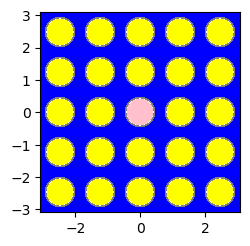

In [3]:
# create the surfaces

r_fo = 0.4096 # cm, fuel outer radius
r_ci = 0.4179 # cm, clad inner radius
r_co = 0.4751 # cm, clad outer radius

fuel_outer_radius = openmc.ZCylinder(r=r_fo);
clad_inner_radius = openmc.ZCylinder(r=r_ci);
clad_outer_radius = openmc.ZCylinder(r=r_co);

# define the regions

fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius
coolant_region = +clad_outer_radius

# define cells for a universe containing a fuel (UO2) pin

fuel = openmc.Cell(name='fuel');
fuel.fill = uo2;
fuel.region = fuel_region;

gap_f = openmc.Cell(name='gap_f');
gap_f.region = gap_region;
# no fill.  Makes it void by default

clad_f = openmc.Cell(name='clad_f');
clad_f.fill = zirc4;
clad_f.region = clad_region

coolant_f = openmc.Cell(name='coolant_f');
coolant_f.fill = water;
coolant_f.region = coolant_region;

# define the fuel pin universe

fp = openmc.Universe()
fp.add_cells([fuel,gap_f,clad_f,coolant_f]);

# define cells for a target pin universe

fuel_t = openmc.Cell(name='fuel_t');
fuel_t.region = fuel_region;
fuel_t.fill = target

gap_t = openmc.Cell(name='gap_t');
gap_t.region = gap_region;

clad_t = openmc.Cell(name='clad_t');
clad_t.fill = zirc4
clad_t.region = clad_region;

coolant_t = openmc.Cell(name='coolant_t');
coolant_t.fill = water
coolant_t.region = coolant_region 

tp = openmc.Universe()
tp.add_cells([fuel_t,gap_t,clad_t,coolant_t]);

# We also want to define an "all coolant" universe to use with the lattice we will be making.

all_coolant_cell = openmc.Cell(name='all_coolant_cell')
all_coolant_cell.fill = water
# with no region, water will just be everywhere (I think!!)

cu = openmc.Universe()
cu.add_cells([all_coolant_cell]);

# create the assembly/core geometry

P_D = 1.3     # pitch/diameter ratio
N_assy = 5; # number of pins per dimension in the assembly, i.e. N_assy x N_assy 

pitch = r_co*2.*P_D; # cm, pin pitch
a_pitch = N_assy*pitch # cm, assembly pitch

h_assy = 100; # cm, height of the assembly model

assy_box = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -h_assy/2.,h_assy/2.,
                                                  boundary_type='reflective');
# other boundary types = 'periodic' and 'vacuum'

assy_lat = openmc.RectLattice()
assy_lat.center = (0.,0.)
assy_lat.dimension = [N_assy,N_assy]
assy_lat.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
assy_lat.pitch = [pitch,pitch]
assy_lat.universes=[
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, tp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp]
]
assy_lat.outer = cu; # coolant universe is outside of the assy lattice.

assy_u = openmc.Universe()
assy_cell = openmc.Cell()
assy_cell.fill = assy_lat;
assy_cell.region = -assy_box
assy_u.add_cell(assy_cell);

# define a colors dictionary so we can tell OpenMC how to color our plots
colors = {}
colors[water]='blue';
colors[uo2]='yellow';
colors[zirc4]='gray';
colors[target]='pink';

# plot the assembly universe and make sure it looks right.
assy_u.plot(width=(a_pitch,a_pitch),color_by='material',colors=colors)

In [4]:
# create the geometry and export to XML

geometry = openmc.Geometry()
geometry.root_universe = assy_u

geometry.export_to_xml()

# Add volume calculation to materials and write materials to xml

# volume calc for target:
num_tgt_pins = 1;
num_fuel_pins = 24;
target.volume = np.pi*(r_fo**2)*h_assy*num_tgt_pins
uo2.volume = np.pi*(r_fo**2)*h_assy*num_fuel_pins

materials = openmc.Materials([target, uo2, zirc4, water]);
materials.export_to_xml();

### Tallies

In [5]:
# filters for energy, cells, and reactions
cell_filter = openmc.CellFilter(fuel_t); # measure in the target material cell

cell_filter_assy = openmc.CellFilter(assy_cell);

# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# avg flux for the whole core
flux_avg = openmc.Tally(name='avg flux')
flux_avg.scores = ['flux'];
flux_avg.filters = [cell_filter_assy, energy_filter];



# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

# tally fission in Np238
np238_fission_t = openmc.Tally(name='Np238_fiss')
np238_fission_t.scores = ['fission']
np238_fission_t.nuclides = ['Np238']
np238_fission_t.filters = [cell_filter,efilter_capture]

# tally (n,2n) in Np237
np237_n2n_t = openmc.Tally(name='Np237_n2n')
np237_n2n_t.scores = ['(n,2n)']
np237_n2n_t.nuclides = ['Np237']
np237_n2n_t.filters = [cell_filter]


# tally fission in Pu-238
pu238_fission_t = openmc.Tally(name='Pu238_fiss')
pu238_fission_t.scores = ['fission']
pu238_fission_t.nuclides = ['Pu238']
pu238_fission_t.filters = [cell_filter]

# tally (n,gamma) in Pu-238
pu238_capture_t = openmc.Tally(name='Pu238_capture')
pu238_capture_t.scores = ['(n,gamma)']
pu238_capture_t.nuclides = ['Pu238']
pu238_capture_t.filters = [cell_filter]

tallies = openmc.Tallies([flux_avg, flux_target, np237_capture_t, np237_n2n_t,
                         np238_fission_t, pu238_fission_t, pu238_capture_t]);
tallies.export_to_xml()

In [6]:
# create settings for criticality

settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-a_pitch/2.,-a_pitch/2.,-h_assy/2.),
                      upper_right=(a_pitch/2.,a_pitch/2.,h_assy/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src;

settings.export_to_xml();

## Conduct Depletion Calculation

In [7]:
model = openmc.model.Model(geometry,materials,settings,tallies)
operator = openmc.deplete.CoupledOperator(model,"chain_casl_pwr.xml");

# Typical PWR power_density = 30.5 W/gHM
power_density = 30.5; # W/gHM
days = 24*3600;
time_steps = [0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.5*days, 0.5*days,
              1.0*days, 1.0*days, 1.0*days, 1.0*days, 4.0*days, 4.0*days, 
              4.0*days, 4.0*days,4.0*days, 4*days, 4*days, 4*days,4*days];

cecm = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density);


repeat_depletion = False;

if(repeat_depletion):
    cecm.integrate()



                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5


 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd106.h5
 Reading Pd107 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd107.h5
 Reading Pd108 from /home/sblair/OMC_DATA/

 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5


          2500K


 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5
 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5


          1200K
          2500K


 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce143.h5
 Reading Ce144 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce144.h5
 Reading Pr141 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr141.h5
 Reading Pr142 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr142.h5
 Reading Pr143 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr143.h5
 Reading Nd142 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd142.h5
 Reading Nd143 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd143.h5
 Reading Nd144 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd144.h5
 Reading Nd145 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd145.h5
 Reading Nd146 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd146.h5
 Reading Nd147 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd147.h5
 Reading Nd148 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy163.h5
 Reading Dy164 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy164.h5
 Reading Ho165 from /home/sblair/OMC_DATA/endfb71_hdf5/Ho165.h5
 Reading Er162 from /home/sblair/OMC_DAT

      112/1    1.33431    1.34749 +/- 0.00147
      113/1    1.35622    1.34763 +/- 0.00145
      114/1    1.34833    1.34764 +/- 0.00143
      115/1    1.35891    1.34782 +/- 0.00142
      116/1    1.35546    1.34793 +/- 0.00140
      117/1    1.35615    1.34806 +/- 0.00138
      118/1    1.35061    1.34809 +/- 0.00136
      119/1    1.35719    1.34822 +/- 0.00135
      120/1    1.34797    1.34822 +/- 0.00133
      121/1    1.34038    1.34811 +/- 0.00132
      122/1    1.35330    1.34818 +/- 0.00130
      123/1    1.34725    1.34817 +/- 0.00128
      124/1    1.34466    1.34812 +/- 0.00127
      125/1    1.35029    1.34815 +/- 0.00125
      126/1    1.34131    1.34806 +/- 0.00124
      127/1    1.35262    1.34812 +/- 0.00122
      128/1    1.34524    1.34808 +/- 0.00121
      129/1    1.36651    1.34832 +/- 0.00121
      130/1    1.34122    1.34823 +/- 0.00120
      131/1    1.32438    1.34793 +/- 0.00122
      132/1    1.35109    1.34797 +/- 0.00121
      133/1    1.37400    1.34829 

       81/1    1.34456    1.34684 +/- 0.00198
       82/1    1.32956    1.34630 +/- 0.00199
       83/1    1.34646    1.34631 +/- 0.00193
       84/1    1.34384    1.34624 +/- 0.00187
       85/1    1.34690    1.34625 +/- 0.00182
       86/1    1.32550    1.34568 +/- 0.00186
       87/1    1.33660    1.34543 +/- 0.00182
       88/1    1.34310    1.34537 +/- 0.00178
       89/1    1.34904    1.34547 +/- 0.00173
       90/1    1.34337    1.34541 +/- 0.00169
       91/1    1.34241    1.34534 +/- 0.00165
       92/1    1.32868    1.34494 +/- 0.00166
       93/1    1.34525    1.34495 +/- 0.00162
       94/1    1.33119    1.34464 +/- 0.00161
       95/1    1.36762    1.34515 +/- 0.00166
       96/1    1.34123    1.34506 +/- 0.00162
       97/1    1.33418    1.34483 +/- 0.00160
       98/1    1.33159    1.34456 +/- 0.00160
       99/1    1.33661    1.34439 +/- 0.00157
      100/1    1.34199    1.34435 +/- 0.00154
      101/1    1.34094    1.34428 +/- 0.00151
      102/1    1.35451    1.34448 

       47/1    1.34606
       48/1    1.34549
       49/1    1.32522
       50/1    1.34039
       51/1    1.34157
       52/1    1.34076    1.34117 +/- 0.00040
       53/1    1.33768    1.34001 +/- 0.00119
       54/1    1.33230    1.33808 +/- 0.00210
       55/1    1.34869    1.34020 +/- 0.00267
       56/1    1.32486    1.33764 +/- 0.00336
       57/1    1.31269    1.33408 +/- 0.00456
       58/1    1.32312    1.33271 +/- 0.00418
       59/1    1.35003    1.33463 +/- 0.00416
       60/1    1.33976    1.33515 +/- 0.00375
       61/1    1.32753    1.33445 +/- 0.00347
       62/1    1.31928    1.33319 +/- 0.00341
       63/1    1.32711    1.33272 +/- 0.00317
       64/1    1.32426    1.33212 +/- 0.00300
       65/1    1.33477    1.33229 +/- 0.00279
       66/1    1.35504    1.33372 +/- 0.00298
       67/1    1.33657    1.33388 +/- 0.00280
       68/1    1.34591    1.33455 +/- 0.00272
       69/1    1.37823    1.33685 +/- 0.00345
       70/1    1.34833    1.33742 +/- 0.00333
       71/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.35969
        2/1    1.34743
        3/1    1.32983
        4/1    1.32399
        5/1    1.32546
        6/1    1.35438
        7/1    1.31162
        8/1    1.32713
        9/1    1.33989
       10/1    1.33851
       11/1    1.33770
       12/1    1.33073
       13/1    1.33073
       14/1    1.35008
       15/1    1.34113
       16/1    1.32629
       17/1    1.34295
       18/1    1.32383
       19/1    1.34425
       20/1    1.32198
       21/1    1.33357
       22/1    1.33337
       23/1    1.32332
       24/1    1.33197
       25/1    1.34579
       26/1    1.33072
       27/1    1.33745
       28/1    1.31563
       29/1    1.34660
       30/1    1.34373
       31/1    1.31315
       32/1    1.34390
       3

      200/1    1.32939    1.33277 +/- 0.00098
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8605e+02 seconds
   Time in transport only          = 2.8485e+02 seconds
   Time in inactive batches        = 4.4541e+01 seconds
   Time in active batches          = 2.4151e+02 seconds
   Time synchronizing fission bank = 4.7220e-01 seconds
     Sampling source sites         = 4.2038e-01 seconds
     SEND/RECV source sites        = 5.0602e-02 seconds
   Time accumulating tallies       = 4.8388e-01 seconds
   Time writing statepoints        = 2.3216e-02 seconds
 Total time for finalization       = 3.4303e-03 seconds
 Total time elapsed                = 2.8630e+02 seconds
 Calculation Rate (inactive)       = 22451 particles/second
 Calculation Rate (active)         = 12421.9

      169/1    1.31361    1.32861 +/- 0.00109
      170/1    1.33932    1.32870 +/- 0.00109
      171/1    1.33624    1.32876 +/- 0.00108
      172/1    1.33885    1.32885 +/- 0.00108
      173/1    1.31969    1.32877 +/- 0.00107
      174/1    1.34783    1.32893 +/- 0.00107
      175/1    1.33299    1.32896 +/- 0.00106
      176/1    1.33447    1.32900 +/- 0.00106
      177/1    1.34187    1.32910 +/- 0.00105
      178/1    1.32699    1.32909 +/- 0.00104
      179/1    1.34771    1.32923 +/- 0.00105
      180/1    1.30839    1.32907 +/- 0.00105
      181/1    1.32147    1.32901 +/- 0.00104
      182/1    1.32962    1.32902 +/- 0.00104
      183/1    1.33397    1.32905 +/- 0.00103
      184/1    1.33482    1.32910 +/- 0.00102
      185/1    1.31769    1.32901 +/- 0.00102
      186/1    1.31211    1.32889 +/- 0.00102
      187/1    1.31837    1.32881 +/- 0.00101
      188/1    1.32336    1.32877 +/- 0.00101
      189/1    1.32344    1.32873 +/- 0.00100
      190/1    1.31311    1.32862 

      138/1    1.32146    1.32226 +/- 0.00115
      139/1    1.32013    1.32223 +/- 0.00114
      140/1    1.32166    1.32223 +/- 0.00113
      141/1    1.30268    1.32201 +/- 0.00114
      142/1    1.30683    1.32185 +/- 0.00114
      143/1    1.31098    1.32173 +/- 0.00113
      144/1    1.32711    1.32179 +/- 0.00112
      145/1    1.32879    1.32186 +/- 0.00111
      146/1    1.31679    1.32181 +/- 0.00110
      147/1    1.32669    1.32186 +/- 0.00109
      148/1    1.33764    1.32202 +/- 0.00109
      149/1    1.30986    1.32190 +/- 0.00109
      150/1    1.31499    1.32183 +/- 0.00108
      151/1    1.31316    1.32174 +/- 0.00107
      152/1    1.32823    1.32180 +/- 0.00106
      153/1    1.35797    1.32216 +/- 0.00111
      154/1    1.32818    1.32221 +/- 0.00110
      155/1    1.34021    1.32238 +/- 0.00110
      156/1    1.32830    1.32244 +/- 0.00109
      157/1    1.33650    1.32257 +/- 0.00109
      158/1    1.32265    1.32257 +/- 0.00108
      159/1    1.30492    1.32241 

      107/1    1.32573    1.32330 +/- 0.00173
      108/1    1.33796    1.32356 +/- 0.00172
      109/1    1.30923    1.32331 +/- 0.00170
      110/1    1.31084    1.32310 +/- 0.00169
      111/1    1.32215    1.32309 +/- 0.00166
      112/1    1.32908    1.32319 +/- 0.00164
      113/1    1.32692    1.32324 +/- 0.00161
      114/1    1.32339    1.32325 +/- 0.00159
      115/1    1.31849    1.32317 +/- 0.00156
      116/1    1.32493    1.32320 +/- 0.00154
      117/1    1.32847    1.32328 +/- 0.00152
      118/1    1.31766    1.32320 +/- 0.00150
      119/1    1.31850    1.32313 +/- 0.00148
      120/1    1.33108    1.32324 +/- 0.00146
      121/1    1.33009    1.32334 +/- 0.00144
      122/1    1.32750    1.32340 +/- 0.00142
      123/1    1.33008    1.32349 +/- 0.00141
      124/1    1.30724    1.32327 +/- 0.00141
      125/1    1.33042    1.32336 +/- 0.00139
      126/1    1.33486    1.32352 +/- 0.00138
      127/1    1.30443    1.32327 +/- 0.00138
      128/1    1.32989    1.32335 

       76/1    1.33263    1.31833 +/- 0.00246
       77/1    1.33076    1.31879 +/- 0.00241
       78/1    1.30658    1.31835 +/- 0.00237
       79/1    1.31790    1.31834 +/- 0.00228
       80/1    1.31935    1.31837 +/- 0.00221
       81/1    1.34973    1.31938 +/- 0.00236
       82/1    1.30816    1.31903 +/- 0.00231
       83/1    1.29332    1.31825 +/- 0.00237
       84/1    1.32996    1.31860 +/- 0.00233
       85/1    1.30414    1.31819 +/- 0.00230
       86/1    1.32548    1.31839 +/- 0.00224
       87/1    1.32800    1.31865 +/- 0.00220
       88/1    1.33251    1.31901 +/- 0.00217
       89/1    1.31241    1.31884 +/- 0.00212
       90/1    1.31245    1.31868 +/- 0.00207
       91/1    1.30487    1.31835 +/- 0.00205
       92/1    1.33554    1.31876 +/- 0.00204
       93/1    1.33072    1.31903 +/- 0.00201
       94/1    1.31417    1.31892 +/- 0.00197
       95/1    1.32804    1.31913 +/- 0.00194
       96/1    1.32266    1.31920 +/- 0.00189
       97/1    1.33481    1.31953 

       37/1    1.32380
       38/1    1.32955
       39/1    1.31484
       40/1    1.31914
       41/1    1.29277
       42/1    1.31147
       43/1    1.31149
       44/1    1.30996
       45/1    1.31855
       46/1    1.30995
       47/1    1.30533
       48/1    1.31282
       49/1    1.31142
       50/1    1.32472
       51/1    1.31979
       52/1    1.31088    1.31533 +/- 0.00446
       53/1    1.30932    1.31333 +/- 0.00326
       54/1    1.31462    1.31365 +/- 0.00233
       55/1    1.28478    1.30787 +/- 0.00605
       56/1    1.30018    1.30659 +/- 0.00510
       57/1    1.31650    1.30801 +/- 0.00454
       58/1    1.32889    1.31062 +/- 0.00472
       59/1    1.33284    1.31309 +/- 0.00484
       60/1    1.32223    1.31400 +/- 0.00442
       61/1    1.31698    1.31427 +/- 0.00401
       62/1    1.32984    1.31557 +/- 0.00388
       63/1    1.29624    1.31408 +/- 0.00387
       64/1    1.31343    1.31404 +/- 0.00358
       65/1    1.30667    1.31354 +/- 0.00337
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.31862
        2/1    1.32182
        3/1    1.31546
        4/1    1.33014
        5/1    1.30612
        6/1    1.31374
        7/1    1.32119
        8/1    1.32101
        9/1    1.32954
       10/1    1.31151
       11/1    1.32246
       12/1    1.29310
       13/1    1.30937
       14/1    1.31182
       15/1    1.32066
       16/1    1.31351
       17/1    1.33472
       18/1    1.30341
       19/1    1.30661
       20/1    1.30049
       21/1    1.32200
       22/1    1.31467
       23/1    1.29805
       24/1    1.32683
       25/1    1.29651
       26/1    1.29998
       27/1    1.32718
       28/1    1.32946
       29/1    1.30803
       30/1    1.32523
       31/1    1.31220
       32/1    1.30585
       3

      200/1    1.31795    1.31405 +/- 0.00097
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8469e+02 seconds
   Time in transport only          = 2.8345e+02 seconds
   Time in inactive batches        = 4.4299e+01 seconds
   Time in active batches          = 2.4039e+02 seconds
   Time synchronizing fission bank = 4.9451e-01 seconds
     Sampling source sites         = 4.4082e-01 seconds
     SEND/RECV source sites        = 5.2413e-02 seconds
   Time accumulating tallies       = 4.7518e-01 seconds
   Time writing statepoints        = 1.9982e-02 seconds
 Total time for finalization       = 3.0276e-03 seconds
 Total time elapsed                = 2.8494e+02 seconds
 Calculation Rate (inactive)       = 22574 particles/second
 Calculation Rate (active)         = 12479.9

      169/1    1.32147    1.31170 +/- 0.00103
      170/1    1.31243    1.31171 +/- 0.00102
      171/1    1.30165    1.31162 +/- 0.00102
      172/1    1.30283    1.31155 +/- 0.00101
      173/1    1.32707    1.31168 +/- 0.00101
      174/1    1.30684    1.31164 +/- 0.00100
      175/1    1.31383    1.31166 +/- 0.00100
      176/1    1.29863    1.31155 +/- 0.00099
      177/1    1.31587    1.31159 +/- 0.00099
      178/1    1.29691    1.31147 +/- 0.00099
      179/1    1.30410    1.31141 +/- 0.00098
      180/1    1.31968    1.31148 +/- 0.00097
      181/1    1.30749    1.31145 +/- 0.00097
      182/1    1.31318    1.31146 +/- 0.00096
      183/1    1.31605    1.31150 +/- 0.00095
      184/1    1.29431    1.31137 +/- 0.00095
      185/1    1.31930    1.31143 +/- 0.00095
      186/1    1.29310    1.31129 +/- 0.00095
      187/1    1.30576    1.31125 +/- 0.00095
      188/1    1.30032    1.31117 +/- 0.00094
      189/1    1.31422    1.31119 +/- 0.00094
      190/1    1.31119    1.31119 

      138/1    1.30630    1.31018 +/- 0.00112
      139/1    1.31119    1.31019 +/- 0.00111
      140/1    1.31684    1.31027 +/- 0.00110
      141/1    1.31255    1.31029 +/- 0.00109
      142/1    1.31450    1.31034 +/- 0.00108
      143/1    1.29973    1.31022 +/- 0.00107
      144/1    1.32438    1.31037 +/- 0.00107
      145/1    1.32315    1.31051 +/- 0.00107
      146/1    1.30439    1.31044 +/- 0.00106
      147/1    1.30337    1.31037 +/- 0.00105
      148/1    1.29461    1.31021 +/- 0.00105
      149/1    1.29256    1.31003 +/- 0.00106
      150/1    1.29754    1.30991 +/- 0.00105
      151/1    1.32133    1.31002 +/- 0.00105
      152/1    1.33007    1.31022 +/- 0.00106
      153/1    1.30850    1.31020 +/- 0.00105
      154/1    1.30852    1.31018 +/- 0.00104
      155/1    1.29726    1.31006 +/- 0.00103
      156/1    1.31733    1.31013 +/- 0.00103
      157/1    1.32240    1.31024 +/- 0.00102
      158/1    1.31640    1.31030 +/- 0.00102
      159/1    1.29962    1.31020 

      107/1    1.30746    1.30844 +/- 0.00158
      108/1    1.30606    1.30840 +/- 0.00155
      109/1    1.31990    1.30860 +/- 0.00153
      110/1    1.31045    1.30863 +/- 0.00151
      111/1    1.31788    1.30878 +/- 0.00149
      112/1    1.31539    1.30889 +/- 0.00147
      113/1    1.30307    1.30879 +/- 0.00145
      114/1    1.33009    1.30913 +/- 0.00147
      115/1    1.30252    1.30902 +/- 0.00145
      116/1    1.30394    1.30895 +/- 0.00143
      117/1    1.29111    1.30868 +/- 0.00143
      118/1    1.31083    1.30871 +/- 0.00141
      119/1    1.33462    1.30909 +/- 0.00144
      120/1    1.31041    1.30911 +/- 0.00142
      121/1    1.30755    1.30908 +/- 0.00140
      122/1    1.29573    1.30890 +/- 0.00139
      123/1    1.30757    1.30888 +/- 0.00137
      124/1    1.30783    1.30887 +/- 0.00135
      125/1    1.32089    1.30903 +/- 0.00134
      126/1    1.34063    1.30944 +/- 0.00139
      127/1    1.31950    1.30957 +/- 0.00138
      128/1    1.31359    1.30963 

       76/1    1.30979    1.31109 +/- 0.00212
       77/1    1.30029    1.31069 +/- 0.00208
       78/1    1.31427    1.31082 +/- 0.00201
       79/1    1.32717    1.31138 +/- 0.00202
       80/1    1.29947    1.31098 +/- 0.00199
       81/1    1.30712    1.31086 +/- 0.00193
       82/1    1.31487    1.31099 +/- 0.00187
       83/1    1.30639    1.31085 +/- 0.00182
       84/1    1.31475    1.31096 +/- 0.00177
       85/1    1.30996    1.31093 +/- 0.00172
       86/1    1.30938    1.31089 +/- 0.00167
       87/1    1.31112    1.31090 +/- 0.00163
       88/1    1.31765    1.31107 +/- 0.00159
       89/1    1.30727    1.31098 +/- 0.00155
       90/1    1.32061    1.31122 +/- 0.00153
       91/1    1.30656    1.31110 +/- 0.00150
       92/1    1.31044    1.31109 +/- 0.00146
       93/1    1.30178    1.31087 +/- 0.00145
       94/1    1.32366    1.31116 +/- 0.00144
       95/1    1.31411    1.31123 +/- 0.00141
       96/1    1.30290    1.31105 +/- 0.00139
       97/1    1.31728    1.31118 

       37/1    1.33197
       38/1    1.29978
       39/1    1.30405
       40/1    1.30275
       41/1    1.31013
       42/1    1.31965
       43/1    1.29038
       44/1    1.31670
       45/1    1.30364
       46/1    1.31851
       47/1    1.32766
       48/1    1.29237
       49/1    1.30150
       50/1    1.29103
       51/1    1.30264
       52/1    1.30670    1.30467 +/- 0.00203
       53/1    1.30078    1.30337 +/- 0.00175
       54/1    1.32283    1.30824 +/- 0.00502
       55/1    1.32824    1.31224 +/- 0.00558
       56/1    1.31371    1.31248 +/- 0.00456
       57/1    1.30921    1.31202 +/- 0.00388
       58/1    1.31169    1.31197 +/- 0.00336
       59/1    1.30684    1.31140 +/- 0.00302
       60/1    1.29474    1.30974 +/- 0.00317
       61/1    1.31215    1.30996 +/- 0.00288
       62/1    1.30226    1.30931 +/- 0.00271
       63/1    1.28697    1.30760 +/- 0.00302
       64/1    1.31262    1.30795 +/- 0.00282
       65/1    1.30771    1.30794 +/- 0.00263
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.31373
        2/1    1.29987
        3/1    1.31787
        4/1    1.30064
        5/1    1.31851
        6/1    1.31504
        7/1    1.31237
        8/1    1.31038
        9/1    1.30418
       10/1    1.31187
       11/1    1.30779
       12/1    1.30446
       13/1    1.29916
       14/1    1.30836
       15/1    1.30684
       16/1    1.29621
       17/1    1.31535
       18/1    1.31599
       19/1    1.30332
       20/1    1.28191
       21/1    1.30475
       22/1    1.31716
       23/1    1.30755
       24/1    1.30956
       25/1    1.31084
       26/1    1.30466
       27/1    1.29676
       28/1    1.32933
       29/1    1.32253
       30/1    1.29930
       31/1    1.30552
       32/1    1.30841
       3

      200/1    1.30705    1.30826 +/- 0.00086
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8544e+02 seconds
   Time in transport only          = 2.8418e+02 seconds
   Time in inactive batches        = 4.4361e+01 seconds
   Time in active batches          = 2.4108e+02 seconds
   Time synchronizing fission bank = 4.7332e-01 seconds
     Sampling source sites         = 4.1428e-01 seconds
     SEND/RECV source sites        = 5.7839e-02 seconds
   Time accumulating tallies       = 5.1816e-01 seconds
   Time writing statepoints        = 3.2337e-02 seconds
 Total time for finalization       = 3.8544e-03 seconds
 Total time elapsed                = 2.8569e+02 seconds
 Calculation Rate (inactive)       = 22542.2 particles/second
 Calculation Rate (active)         = 12444

      169/1    1.31040    1.30857 +/- 0.00110
      170/1    1.31020    1.30859 +/- 0.00109
      171/1    1.32845    1.30875 +/- 0.00109
      172/1    1.30090    1.30869 +/- 0.00108
      173/1    1.31023    1.30870 +/- 0.00108
      174/1    1.29522    1.30859 +/- 0.00107
      175/1    1.32249    1.30870 +/- 0.00107
      176/1    1.30364    1.30866 +/- 0.00106
      177/1    1.28990    1.30851 +/- 0.00106
      178/1    1.30191    1.30846 +/- 0.00106
      179/1    1.30916    1.30847 +/- 0.00105
      180/1    1.30417    1.30843 +/- 0.00104
      181/1    1.31024    1.30845 +/- 0.00103
      182/1    1.33520    1.30865 +/- 0.00105
      183/1    1.31212    1.30868 +/- 0.00104
      184/1    1.30541    1.30865 +/- 0.00103
      185/1    1.31295    1.30868 +/- 0.00102
      186/1    1.30801    1.30868 +/- 0.00102
      187/1    1.29271    1.30856 +/- 0.00101
      188/1    1.30455    1.30853 +/- 0.00101
      189/1    1.29624    1.30845 +/- 0.00100
      190/1    1.32149    1.30854 

      138/1    1.31168    1.30967 +/- 0.00122
      139/1    1.28948    1.30944 +/- 0.00123
      140/1    1.29472    1.30928 +/- 0.00123
      141/1    1.31164    1.30931 +/- 0.00121
      142/1    1.30385    1.30925 +/- 0.00120
      143/1    1.31248    1.30928 +/- 0.00119
      144/1    1.31648    1.30936 +/- 0.00118
      145/1    1.30391    1.30930 +/- 0.00117
      146/1    1.31304    1.30934 +/- 0.00116
      147/1    1.29966    1.30924 +/- 0.00115
      148/1    1.31413    1.30929 +/- 0.00114
      149/1    1.30243    1.30922 +/- 0.00113
      150/1    1.33071    1.30944 +/- 0.00114
      151/1    1.30607    1.30940 +/- 0.00113
      152/1    1.31301    1.30944 +/- 0.00112
      153/1    1.30570    1.30940 +/- 0.00111
      154/1    1.30468    1.30936 +/- 0.00110
      155/1    1.30362    1.30930 +/- 0.00109
      156/1    1.31545    1.30936 +/- 0.00108
      157/1    1.28920    1.30917 +/- 0.00109
      158/1    1.30708    1.30915 +/- 0.00108
      159/1    1.32087    1.30926 

      107/1    1.30888    1.30664 +/- 0.00132
      108/1    1.28893    1.30633 +/- 0.00133
      109/1    1.32671    1.30668 +/- 0.00135
      110/1    1.31892    1.30688 +/- 0.00134
      111/1    1.31552    1.30702 +/- 0.00133
      112/1    1.32613    1.30733 +/- 0.00134
      113/1    1.31906    1.30752 +/- 0.00134
      114/1    1.31558    1.30764 +/- 0.00132
      115/1    1.30088    1.30754 +/- 0.00130
      116/1    1.32139    1.30775 +/- 0.00130
      117/1    1.29931    1.30762 +/- 0.00129
      118/1    1.31664    1.30776 +/- 0.00128
      119/1    1.29580    1.30758 +/- 0.00127
      120/1    1.30997    1.30762 +/- 0.00125
      121/1    1.31469    1.30772 +/- 0.00124
      122/1    1.29517    1.30754 +/- 0.00123
      123/1    1.31723    1.30768 +/- 0.00122
      124/1    1.30045    1.30758 +/- 0.00121
      125/1    1.33081    1.30789 +/- 0.00123
      126/1    1.30093    1.30780 +/- 0.00122
      127/1    1.30380    1.30774 +/- 0.00121
      128/1    1.30283    1.30768 

       76/1    1.33231    1.30775 +/- 0.00228
       77/1    1.30930    1.30780 +/- 0.00219
       78/1    1.30195    1.30759 +/- 0.00212
       79/1    1.30029    1.30734 +/- 0.00207
       80/1    1.31481    1.30759 +/- 0.00201
       81/1    1.31947    1.30797 +/- 0.00198
       82/1    1.30014    1.30773 +/- 0.00193
       83/1    1.29856    1.30745 +/- 0.00190
       84/1    1.29352    1.30704 +/- 0.00188
       85/1    1.32362    1.30752 +/- 0.00189
       86/1    1.31376    1.30769 +/- 0.00184
       87/1    1.31774    1.30796 +/- 0.00181
       88/1    1.31559    1.30816 +/- 0.00178
       89/1    1.31369    1.30830 +/- 0.00174
       90/1    1.31507    1.30847 +/- 0.00170
       91/1    1.28973    1.30801 +/- 0.00172
       92/1    1.30538    1.30795 +/- 0.00168
       93/1    1.31060    1.30801 +/- 0.00164
       94/1    1.32314    1.30836 +/- 0.00164
       95/1    1.31125    1.30842 +/- 0.00161
       96/1    1.31820    1.30863 +/- 0.00158
       97/1    1.29898    1.30843 

       37/1    1.30774
       38/1    1.30738
       39/1    1.29657
       40/1    1.28937
       41/1    1.29655
       42/1    1.31083
       43/1    1.32872
       44/1    1.30656
       45/1    1.33310
       46/1    1.31789
       47/1    1.30934
       48/1    1.32716
       49/1    1.31173
       50/1    1.30158
       51/1    1.31189
       52/1    1.30677    1.30933 +/- 0.00256
       53/1    1.30966    1.30944 +/- 0.00148
       54/1    1.29372    1.30551 +/- 0.00407
       55/1    1.32077    1.30856 +/- 0.00439
       56/1    1.31007    1.30881 +/- 0.00359
       57/1    1.31598    1.30984 +/- 0.00320
       58/1    1.29928    1.30852 +/- 0.00307
       59/1    1.30363    1.30798 +/- 0.00276
       60/1    1.30333    1.30751 +/- 0.00251
       61/1    1.30417    1.30721 +/- 0.00229
       62/1    1.30265    1.30683 +/- 0.00213
       63/1    1.31011    1.30708 +/- 0.00197
       64/1    1.28305    1.30536 +/- 0.00251
       65/1    1.31156    1.30578 +/- 0.00237
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.30983
        2/1    1.31866
        3/1    1.29613
        4/1    1.31296
        5/1    1.32480
        6/1    1.28516
        7/1    1.29969
        8/1    1.31233
        9/1    1.30345
       10/1    1.31090
       11/1    1.31366
       12/1    1.31758
       13/1    1.30865
       14/1    1.29414
       15/1    1.30148
       16/1    1.30792
       17/1    1.31639
       18/1    1.29305
       19/1    1.28614
       20/1    1.30495
       21/1    1.31155
       22/1    1.31639
       23/1    1.30650
       24/1    1.29150
       25/1    1.32156
       26/1    1.29909
       27/1    1.28364
       28/1    1.28591
       29/1    1.30487
       30/1    1.29961
       31/1    1.28928
       32/1    1.31173
       3

      200/1    1.29301    1.30580 +/- 0.00094
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8313e+02 seconds
   Time in transport only          = 2.8193e+02 seconds
   Time in inactive batches        = 4.4372e+01 seconds
   Time in active batches          = 2.3876e+02 seconds
   Time synchronizing fission bank = 4.4957e-01 seconds
     Sampling source sites         = 3.9926e-01 seconds
     SEND/RECV source sites        = 4.9132e-02 seconds
   Time accumulating tallies       = 4.9792e-01 seconds
   Time writing statepoints        = 1.9399e-02 seconds
 Total time for finalization       = 3.1289e-03 seconds
 Total time elapsed                = 2.8339e+02 seconds
 Calculation Rate (inactive)       = 22536.5 particles/second
 Calculation Rate (active)         = 12564

      169/1    1.30781    1.30239 +/- 0.00095
      170/1    1.30265    1.30239 +/- 0.00095
      171/1    1.28026    1.30220 +/- 0.00096
      172/1    1.30754    1.30225 +/- 0.00095
      173/1    1.32437    1.30243 +/- 0.00096
      174/1    1.29172    1.30234 +/- 0.00096
      175/1    1.31369    1.30243 +/- 0.00095
      176/1    1.30148    1.30242 +/- 0.00094
      177/1    1.31211    1.30250 +/- 0.00094
      178/1    1.29895    1.30247 +/- 0.00093
      179/1    1.29303    1.30240 +/- 0.00093
      180/1    1.32065    1.30254 +/- 0.00093
      181/1    1.30870    1.30259 +/- 0.00093
      182/1    1.28198    1.30243 +/- 0.00093
      183/1    1.30650    1.30246 +/- 0.00093
      184/1    1.31436    1.30255 +/- 0.00092
      185/1    1.30502    1.30257 +/- 0.00092
      186/1    1.30637    1.30260 +/- 0.00091
      187/1    1.28513    1.30247 +/- 0.00091
      188/1    1.30682    1.30250 +/- 0.00091
      189/1    1.31819    1.30261 +/- 0.00091
      190/1    1.30532    1.30263 

      138/1    1.28832    1.29978 +/- 0.00133
      139/1    1.29506    1.29973 +/- 0.00132
      140/1    1.28450    1.29956 +/- 0.00131
      141/1    1.31083    1.29968 +/- 0.00130
      142/1    1.28152    1.29949 +/- 0.00131
      143/1    1.30016    1.29949 +/- 0.00129
      144/1    1.30528    1.29955 +/- 0.00128
      145/1    1.29634    1.29952 +/- 0.00127
      146/1    1.30845    1.29961 +/- 0.00126
      147/1    1.31684    1.29979 +/- 0.00126
      148/1    1.31984    1.30000 +/- 0.00126
      149/1    1.29998    1.30000 +/- 0.00125
      150/1    1.29173    1.29991 +/- 0.00124
      151/1    1.28181    1.29973 +/- 0.00124
      152/1    1.30317    1.29977 +/- 0.00123
      153/1    1.31280    1.29989 +/- 0.00122
      154/1    1.31292    1.30002 +/- 0.00122
      155/1    1.29906    1.30001 +/- 0.00120
      156/1    1.30726    1.30008 +/- 0.00119
      157/1    1.29775    1.30006 +/- 0.00118
      158/1    1.28942    1.29996 +/- 0.00118
      159/1    1.33310    1.30026 

      106/1    1.29636    1.30434 +/- 0.00149
      107/1    1.29368    1.30416 +/- 0.00148
      108/1    1.30490    1.30417 +/- 0.00145
      109/1    1.31377    1.30433 +/- 0.00144
      110/1    1.30380    1.30432 +/- 0.00141
      111/1    1.29580    1.30418 +/- 0.00140
      112/1    1.29619    1.30405 +/- 0.00138
      113/1    1.31438    1.30422 +/- 0.00137
      114/1    1.29570    1.30409 +/- 0.00135
      115/1    1.30005    1.30402 +/- 0.00133
      116/1    1.29336    1.30386 +/- 0.00132
      117/1    1.31156    1.30398 +/- 0.00131
      118/1    1.32313    1.30426 +/- 0.00132
      119/1    1.31905    1.30447 +/- 0.00132
      120/1    1.32516    1.30477 +/- 0.00133
      121/1    1.28729    1.30452 +/- 0.00133
      122/1    1.30605    1.30454 +/- 0.00132
      123/1    1.31202    1.30465 +/- 0.00130
      124/1    1.31440    1.30478 +/- 0.00129
      125/1    1.30321    1.30476 +/- 0.00127
      126/1    1.30252    1.30473 +/- 0.00126
      127/1    1.29680    1.30462 

       75/1    1.29355    1.29850 +/- 0.00184
       76/1    1.30239    1.29865 +/- 0.00177
       77/1    1.28653    1.29820 +/- 0.00176
       78/1    1.28310    1.29766 +/- 0.00178
       79/1    1.27610    1.29692 +/- 0.00187
       80/1    1.29588    1.29689 +/- 0.00181
       81/1    1.30724    1.29722 +/- 0.00178
       82/1    1.30889    1.29759 +/- 0.00176
       83/1    1.30328    1.29776 +/- 0.00172
       84/1    1.29749    1.29775 +/- 0.00167
       85/1    1.30857    1.29806 +/- 0.00165
       86/1    1.29292    1.29792 +/- 0.00161
       87/1    1.29811    1.29792 +/- 0.00156
       88/1    1.30368    1.29807 +/- 0.00153
       89/1    1.29889    1.29809 +/- 0.00149
       90/1    1.32155    1.29868 +/- 0.00157
       91/1    1.29346    1.29855 +/- 0.00153
       92/1    1.30430    1.29869 +/- 0.00150
       93/1    1.30261    1.29878 +/- 0.00147
       94/1    1.31066    1.29905 +/- 0.00146
       95/1    1.29729    1.29901 +/- 0.00143
       96/1    1.29611    1.29895 

       34/1    1.30381
       35/1    1.29079
       36/1    1.29817
       37/1    1.28974
       38/1    1.28077
       39/1    1.30914
       40/1    1.32482
       41/1    1.32373
       42/1    1.29208
       43/1    1.29023
       44/1    1.29605
       45/1    1.29933
       46/1    1.28725
       47/1    1.30517
       48/1    1.30093
       49/1    1.30290
       50/1    1.29989
       51/1    1.30749
       52/1    1.28246    1.29497 +/- 0.01251
       53/1    1.28958    1.29317 +/- 0.00745
       54/1    1.30012    1.29491 +/- 0.00554
       55/1    1.30177    1.29628 +/- 0.00451
       56/1    1.28134    1.29379 +/- 0.00444
       57/1    1.29387    1.29380 +/- 0.00376
       58/1    1.31377    1.29630 +/- 0.00410
       59/1    1.28392    1.29492 +/- 0.00387
       60/1    1.30621    1.29605 +/- 0.00364
       61/1    1.28563    1.29510 +/- 0.00343
       62/1    1.30091    1.29559 +/- 0.00316
       63/1    1.29758    1.29574 +/- 0.00291
       64/1    1.29116    1.29541 

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.28699
        2/1    1.31781
        3/1    1.30073
        4/1    1.30699
        5/1    1.30522
        6/1    1.30004
        7/1    1.30620
        8/1    1.26955
        9/1    1.29464
       10/1    1.30115
       11/1    1.30036
       12/1    1.28013
       13/1    1.30627
       14/1    1.30254
       15/1    1.30381
       16/1    1.27716
       17/1    1.28397
       18/1    1.29907
       19/1    1.30648
       20/1    1.28546
       21/1    1.28058
       22/1    1.29765
       23/1    1.29452
       24/1    1.28913
       25/1    1.28245
       26/1    1.28730
       27/1    1.30358
       28/1    1.29504
       29/1    1.29421
       30/1    1.28514
       31/1    1.30209
       32/1    1.32249
       3

      200/1    1.29595    1.29816 +/- 0.00089
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.9006e+02 seconds
   Time in transport only          = 2.8752e+02 seconds
   Time in inactive batches        = 4.4442e+01 seconds
   Time in active batches          = 2.4561e+02 seconds
   Time synchronizing fission bank = 4.8025e-01 seconds
     Sampling source sites         = 4.2779e-01 seconds
     SEND/RECV source sites        = 5.1229e-02 seconds
   Time accumulating tallies       = 1.7955e+00 seconds
   Time writing statepoints        = 2.5013e-02 seconds
 Total time for finalization       = 3.4202e-03 seconds
 Total time elapsed                = 2.9031e+02 seconds
 Calculation Rate (inactive)       = 22501.5 particles/second
 Calculation Rate (active)         = 12214

      168/1    1.28478    1.29490 +/- 0.00107
      169/1    1.28908    1.29485 +/- 0.00106
      170/1    1.33525    1.29519 +/- 0.00110
      171/1    1.28638    1.29511 +/- 0.00110
      172/1    1.30185    1.29517 +/- 0.00109
      173/1    1.30787    1.29527 +/- 0.00109
      174/1    1.30941    1.29539 +/- 0.00108
      175/1    1.30396    1.29545 +/- 0.00108
      176/1    1.28893    1.29540 +/- 0.00107
      177/1    1.29893    1.29543 +/- 0.00106
      178/1    1.28850    1.29538 +/- 0.00105
      179/1    1.31162    1.29550 +/- 0.00105
      180/1    1.28835    1.29545 +/- 0.00105
      181/1    1.29025    1.29541 +/- 0.00104
      182/1    1.27533    1.29526 +/- 0.00104
      183/1    1.33580    1.29556 +/- 0.00108
      184/1    1.29214    1.29553 +/- 0.00107
      185/1    1.28318    1.29544 +/- 0.00107
      186/1    1.30038    1.29548 +/- 0.00106
      187/1    1.29714    1.29549 +/- 0.00105
      188/1    1.31621    1.29564 +/- 0.00106
      189/1    1.27721    1.29551 

      137/1    1.29581    1.29720 +/- 0.00129
      138/1    1.30293    1.29726 +/- 0.00128
      139/1    1.29311    1.29722 +/- 0.00126
      140/1    1.30986    1.29736 +/- 0.00126
      141/1    1.29080    1.29729 +/- 0.00124
      142/1    1.29611    1.29727 +/- 0.00123
      143/1    1.29411    1.29724 +/- 0.00122
      144/1    1.31014    1.29738 +/- 0.00121
      145/1    1.30277    1.29743 +/- 0.00120
      146/1    1.29662    1.29742 +/- 0.00119
      147/1    1.27300    1.29717 +/- 0.00120
      148/1    1.28144    1.29701 +/- 0.00120
      149/1    1.30900    1.29713 +/- 0.00120
      150/1    1.28965    1.29706 +/- 0.00119
      151/1    1.29205    1.29701 +/- 0.00118
      152/1    1.29622    1.29700 +/- 0.00116
      153/1    1.27021    1.29674 +/- 0.00118
      154/1    1.30051    1.29678 +/- 0.00117
      155/1    1.29961    1.29680 +/- 0.00116
      156/1    1.28319    1.29668 +/- 0.00116
      157/1    1.28516    1.29657 +/- 0.00115
      158/1    1.30440    1.29664 

      105/1    1.29266    1.29901 +/- 0.00121
      106/1    1.27914    1.29866 +/- 0.00124
      107/1    1.29683    1.29862 +/- 0.00122
      108/1    1.31379    1.29889 +/- 0.00123
      109/1    1.28396    1.29863 +/- 0.00123
      110/1    1.29055    1.29850 +/- 0.00122
      111/1    1.28120    1.29821 +/- 0.00123
      112/1    1.29484    1.29816 +/- 0.00121
      113/1    1.28964    1.29802 +/- 0.00120
      114/1    1.29452    1.29797 +/- 0.00119
      115/1    1.28988    1.29785 +/- 0.00117
      116/1    1.29050    1.29773 +/- 0.00116
      117/1    1.30460    1.29784 +/- 0.00115
      118/1    1.28071    1.29758 +/- 0.00116
      119/1    1.30340    1.29767 +/- 0.00115
      120/1    1.27669    1.29737 +/- 0.00117
      121/1    1.29173    1.29729 +/- 0.00115
      122/1    1.30256    1.29736 +/- 0.00114
      123/1    1.27118    1.29700 +/- 0.00118
      124/1    1.31315    1.29722 +/- 0.00118
      125/1    1.29728    1.29722 +/- 0.00117
      126/1    1.27168    1.29689 

       74/1    1.30573    1.29309 +/- 0.00202
       75/1    1.31647    1.29402 +/- 0.00215
       76/1    1.30290    1.29436 +/- 0.00210
       77/1    1.29636    1.29444 +/- 0.00202
       78/1    1.28429    1.29408 +/- 0.00198
       79/1    1.28548    1.29378 +/- 0.00193
       80/1    1.28572    1.29351 +/- 0.00189
       81/1    1.30351    1.29383 +/- 0.00185
       82/1    1.28410    1.29353 +/- 0.00182
       83/1    1.29295    1.29351 +/- 0.00176
       84/1    1.28144    1.29316 +/- 0.00175
       85/1    1.30220    1.29341 +/- 0.00172
       86/1    1.30199    1.29365 +/- 0.00168
       87/1    1.29295    1.29363 +/- 0.00164
       88/1    1.28431    1.29339 +/- 0.00161
       89/1    1.28543    1.29318 +/- 0.00158
       90/1    1.31073    1.29362 +/- 0.00161
       91/1    1.29987    1.29378 +/- 0.00157
       92/1    1.28429    1.29355 +/- 0.00155
       93/1    1.30254    1.29376 +/- 0.00153
       94/1    1.28406    1.29354 +/- 0.00151
       95/1    1.29522    1.29358 

       32/1    1.30377
       33/1    1.29394
       34/1    1.30069
       35/1    1.29584
       36/1    1.28692
       37/1    1.29002
       38/1    1.28414
       39/1    1.30670
       40/1    1.28562
       41/1    1.27350
       42/1    1.30074
       43/1    1.29834
       44/1    1.30144
       45/1    1.29086
       46/1    1.29785
       47/1    1.28501
       48/1    1.27991
       49/1    1.31364
       50/1    1.29095
       51/1    1.30461
       52/1    1.27768    1.29115 +/- 0.01347
       53/1    1.30120    1.29450 +/- 0.00847
       54/1    1.29601    1.29488 +/- 0.00600
       55/1    1.27742    1.29139 +/- 0.00581
       56/1    1.30643    1.29389 +/- 0.00537
       57/1    1.28629    1.29281 +/- 0.00466
       58/1    1.29649    1.29327 +/- 0.00407
       59/1    1.28859    1.29275 +/- 0.00362
       60/1    1.32590    1.29606 +/- 0.00464
       61/1    1.30388    1.29677 +/- 0.00425
       62/1    1.27719    1.29514 +/- 0.00421
       63/1    1.28191    1.29412 

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.29350
        2/1    1.31203
        3/1    1.27103
        4/1    1.29519
        5/1    1.29823
        6/1    1.30236
        7/1    1.29746
        8/1    1.29637
        9/1    1.26981
       10/1    1.28922
       11/1    1.27953
       12/1    1.30590
       13/1    1.27753
       14/1    1.28251
       15/1    1.29219
       16/1    1.29614
       17/1    1.30351
       18/1    1.29027
       19/1    1.29018
       20/1    1.28719
       21/1    1.24936
       22/1    1.29640
       23/1    1.28569
       24/1    1.29602
       25/1    1.28350
       26/1    1.27442
       27/1    1.30394
       28/1    1.30458
       29/1    1.29505
       30/1    1.29189
       31/1    1.28401
       32/1    1.29113
       3

      200/1    1.30258    1.29255 +/- 0.00087
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.9342e+02 seconds
   Time in transport only          = 2.9129e+02 seconds
   Time in inactive batches        = 4.6601e+01 seconds
   Time in active batches          = 2.4682e+02 seconds
   Time synchronizing fission bank = 4.6873e-01 seconds
     Sampling source sites         = 4.1573e-01 seconds
     SEND/RECV source sites        = 5.1752e-02 seconds
   Time accumulating tallies       = 1.3954e+00 seconds
   Time writing statepoints        = 2.8505e-02 seconds
 Total time for finalization       = 3.9680e-03 seconds
 Total time elapsed                = 2.9367e+02 seconds
 Calculation Rate (inactive)       = 21458.8 particles/second
 Calculation Rate (active)         = 12154

      168/1    1.28782    1.29340 +/- 0.00109
      169/1    1.30032    1.29346 +/- 0.00108
      170/1    1.31108    1.29361 +/- 0.00108
      171/1    1.28983    1.29358 +/- 0.00107
      172/1    1.28675    1.29352 +/- 0.00107
      173/1    1.30139    1.29359 +/- 0.00106
      174/1    1.30021    1.29364 +/- 0.00105
      175/1    1.31075    1.29378 +/- 0.00105
      176/1    1.29453    1.29378 +/- 0.00104
      177/1    1.29770    1.29381 +/- 0.00104
      178/1    1.28780    1.29377 +/- 0.00103
      179/1    1.28517    1.29370 +/- 0.00102
      180/1    1.30747    1.29380 +/- 0.00102
      181/1    1.28526    1.29374 +/- 0.00102
      182/1    1.29131    1.29372 +/- 0.00101
      183/1    1.28554    1.29366 +/- 0.00100
      184/1    1.28593    1.29360 +/- 0.00100
      185/1    1.28390    1.29353 +/- 0.00099
      186/1    1.30060    1.29358 +/- 0.00099
      187/1    1.28735    1.29354 +/- 0.00098
      188/1    1.27956    1.29344 +/- 0.00098
      189/1    1.29333    1.29343 

      137/1    1.27464    1.29245 +/- 0.00132
      138/1    1.28030    1.29231 +/- 0.00131
      139/1    1.27701    1.29214 +/- 0.00131
      140/1    1.28573    1.29207 +/- 0.00129
      141/1    1.28726    1.29201 +/- 0.00128
      142/1    1.31269    1.29224 +/- 0.00129
      143/1    1.28820    1.29219 +/- 0.00127
      144/1    1.30132    1.29229 +/- 0.00126
      145/1    1.30219    1.29240 +/- 0.00125
      146/1    1.27859    1.29225 +/- 0.00125
      147/1    1.29360    1.29227 +/- 0.00124
      148/1    1.28808    1.29222 +/- 0.00122
      149/1    1.32181    1.29252 +/- 0.00125
      150/1    1.31030    1.29270 +/- 0.00125
      151/1    1.30373    1.29281 +/- 0.00124
      152/1    1.30502    1.29293 +/- 0.00123
      153/1    1.29824    1.29298 +/- 0.00122
      154/1    1.30254    1.29307 +/- 0.00121
      155/1    1.29395    1.29308 +/- 0.00120
      156/1    1.29740    1.29312 +/- 0.00119
      157/1    1.28296    1.29303 +/- 0.00118
      158/1    1.29792    1.29307 

      105/1    1.28349    1.29248 +/- 0.00150
      106/1    1.29080    1.29245 +/- 0.00147
      107/1    1.28363    1.29230 +/- 0.00145
      108/1    1.27520    1.29200 +/- 0.00146
      109/1    1.28815    1.29194 +/- 0.00143
      110/1    1.30284    1.29212 +/- 0.00142
      111/1    1.27131    1.29178 +/- 0.00144
      112/1    1.29082    1.29176 +/- 0.00142
      113/1    1.28630    1.29167 +/- 0.00140
      114/1    1.29656    1.29175 +/- 0.00138
      115/1    1.28347    1.29162 +/- 0.00136
      116/1    1.29234    1.29163 +/- 0.00134
      117/1    1.28570    1.29155 +/- 0.00132
      118/1    1.30270    1.29171 +/- 0.00131
      119/1    1.30612    1.29192 +/- 0.00131
      120/1    1.28618    1.29184 +/- 0.00130
      121/1    1.28465    1.29173 +/- 0.00128
      122/1    1.29425    1.29177 +/- 0.00126
      123/1    1.28091    1.29162 +/- 0.00125
      124/1    1.29680    1.29169 +/- 0.00124
      125/1    1.27483    1.29147 +/- 0.00124
      126/1    1.29795    1.29155 

       74/1    1.28847    1.29046 +/- 0.00254
       75/1    1.28259    1.29015 +/- 0.00245
       76/1    1.29794    1.29044 +/- 0.00238
       77/1    1.29336    1.29055 +/- 0.00229
       78/1    1.29742    1.29080 +/- 0.00222
       79/1    1.30279    1.29121 +/- 0.00218
       80/1    1.29671    1.29140 +/- 0.00212
       81/1    1.27451    1.29085 +/- 0.00212
       82/1    1.29370    1.29094 +/- 0.00205
       83/1    1.28662    1.29081 +/- 0.00199
       84/1    1.28078    1.29051 +/- 0.00196
       85/1    1.29433    1.29062 +/- 0.00190
       86/1    1.28502    1.29047 +/- 0.00186
       87/1    1.27563    1.29007 +/- 0.00185
       88/1    1.27904    1.28978 +/- 0.00182
       89/1    1.28909    1.28976 +/- 0.00178
       90/1    1.30341    1.29010 +/- 0.00176
       91/1    1.29831    1.29030 +/- 0.00173
       92/1    1.27982    1.29005 +/- 0.00171
       93/1    1.28105    1.28984 +/- 0.00168
       94/1    1.28540    1.28974 +/- 0.00165
       95/1    1.28113    1.28955 

       33/1    1.29912
       34/1    1.28583
       35/1    1.31102
       36/1    1.30283
       37/1    1.28859
       38/1    1.30964
       39/1    1.29254
       40/1    1.29330
       41/1    1.30049
       42/1    1.28095
       43/1    1.30060
       44/1    1.28785
       45/1    1.30391
       46/1    1.28367
       47/1    1.31179
       48/1    1.30331
       49/1    1.28853
       50/1    1.27627
       51/1    1.27843
       52/1    1.27897    1.27870 +/- 0.00027
       53/1    1.28849    1.28196 +/- 0.00327
       54/1    1.28459    1.28262 +/- 0.00240
       55/1    1.28565    1.28322 +/- 0.00196
       56/1    1.29841    1.28576 +/- 0.00299
       57/1    1.30244    1.28814 +/- 0.00348
       58/1    1.27122    1.28602 +/- 0.00368
       59/1    1.28473    1.28588 +/- 0.00325
       60/1    1.30559    1.28785 +/- 0.00351
       61/1    1.28128    1.28725 +/- 0.00323
       62/1    1.29575    1.28796 +/- 0.00303
       63/1    1.28114    1.28744 +/- 0.00284
       64/1

## Post-Process Results

In [8]:
results = openmc.deplete.Results('./depletion_results.h5')

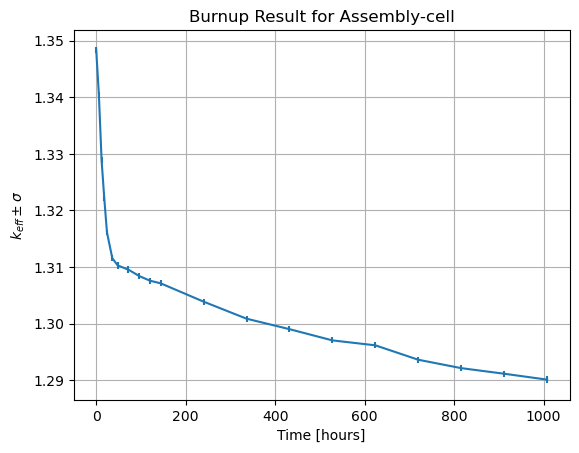

In [9]:
time, k = results.get_keff()
time /= (60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for Assembly-cell')
plt.xlabel('Time [hours]')
plt.ylabel('$k_{eff} \pm \sigma$')
plt.grid()

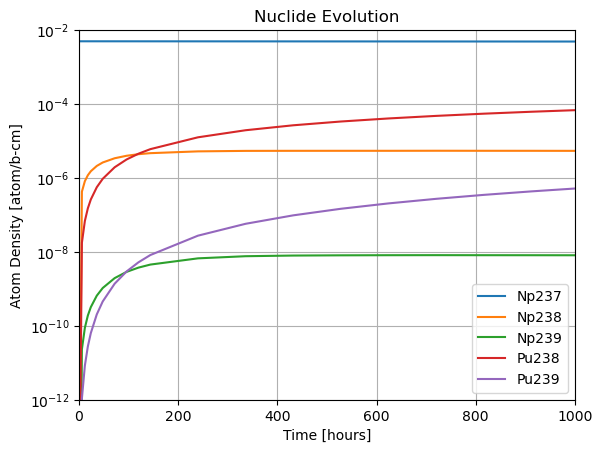

In [10]:
# check the materials.xml file to get the material number for the target
time, np237 = results.get_atoms("3","Np237",nuc_units="atom/b-cm",
                               time_units="h")
time, np238 = results.get_atoms("3","Np238",nuc_units="atom/b-cm",
                               time_units="h")
time, np239 = results.get_atoms("3","Np239",nuc_units="atom/b-cm",
                               time_units="h")
time, pu238 = results.get_atoms("3","Pu238",nuc_units="atom/b-cm",
                                time_units="h")
time, pu239 = results.get_atoms("3","Pu239",nuc_units="atom/b-cm",
                               time_units="h")

plt.semilogy(time,np237,label="Np237")
plt.semilogy(time,np238,label="Np238")
plt.semilogy(time,np239,label="Np239")
plt.semilogy(time,pu238,label="Pu238")
plt.semilogy(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([0,1000,1e-12,1e-2])
plt.legend()

### Re-do plots in relative atom density

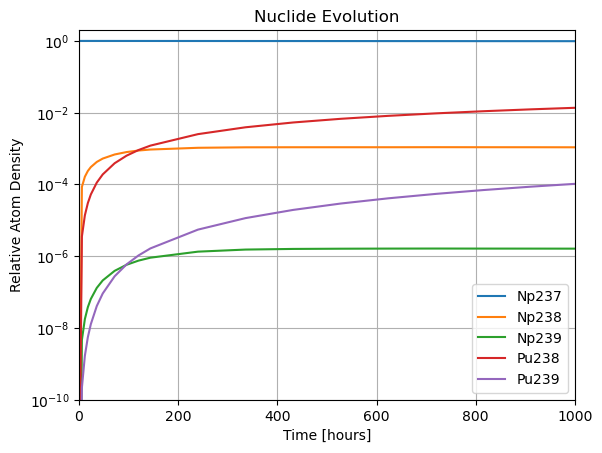

In [11]:
np237_r = np237/np237[0]
np238_r = np238/np237[0]
np239_r = np239/np237[0]
pu238_r = pu238/np237[0]
pu239_r = pu239/np237[0]

plt.semilogy(time,np237_r,label="Np237")
plt.semilogy(time,np238_r,label="Np238")
plt.semilogy(time,np239_r,label="Np239")
plt.semilogy(time,pu238_r,label="Pu238")
plt.semilogy(time,pu239_r,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Relative Atom Density")
plt.grid()
plt.axis([0,1000,1e-10,2e-0])
plt.legend()

## Reaction Rate Results

For example, for the Np237 target, it might be interesting to plot the 'absorption', 'fission', and (maybe) (n,2n) reaction rates as those were the three reactions mentioned on the CSNR slide.

Update: 'absorption' is not tallied by default in the depletion calculation.  But, at least, (n,gamma), fission, and (n,2n) are.

Update 2: this cannot be correct.  Will try to get this data from individual statepoint files.

In [12]:
times, np237_abs_rates = results.get_reaction_rate('3','Np237','(n,gamma)')
times, np237_fiss_rates = results.get_reaction_rate('3','Np237','fission')
times, np237_n2n_rates = results.get_reaction_rate('3','Np237','(n,2n)')

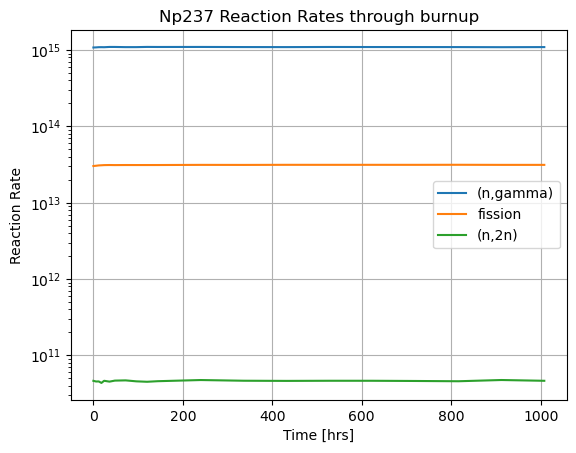

In [13]:
times /= 3600;

plt.semilogy(times,np237_abs_rates,label='(n,gamma)')
plt.semilogy(times,np237_fiss_rates,label='fission')
plt.semilogy(times,np237_n2n_rates,label='(n,2n)')
plt.grid()
plt.title('Np237 Reaction Rates through burnup')
plt.xlabel('Time [hrs]')
plt.ylabel('Reaction Rate')
plt.legend()

### Try again - but with StatePoint file(s)

In [14]:
sp = openmc.StatePoint('openmc_simulation_n18.h5')

In [15]:
sp.tallies

{2: Tally
 	ID             =	2
 	Name           =	avg flux
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength,
 1: Tally
 	ID             =	1
 	Name           =	flux in target
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength,
 3: Tally
 	ID             =	3
 	Name           =	Np237_total_capture
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	Np237
 	Scores         =	['(n,gamma)']
 	Estimator      =	tracklength,
 5: Tally
 	ID             =	5
 	Name           =	Np237_n2n
 	Filters        =	CellFilter
 	Nuclides       =	Np237
 	Scores         =	['(n,2n)']
 	Estimator      =	tracklength,
 4: Tally
 	ID             =	4
 	Name           =	Np238_fiss
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	Np238
 	Scores         =	['fission']
 	Estimator      =	tracklength,
 6: Tally
 	ID             =	6
 	Name       

In [16]:
avg_flux = sp.get_tally(name='avg flux')
avg_flux_df = avg_flux.get_pandas_dataframe();
avg_flux_vals = avg_flux_df['mean'].to_numpy();

In [17]:
avg_flux_df.head()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,10,0.001000,0.001023,total,flux,0.000035,0.000002
1,10,0.001023,0.001047,total,flux,0.000041,0.000002
2,10,0.001047,0.001072,total,flux,0.000040,0.000002
3,10,0.001072,0.001096,total,flux,0.000044,0.000003
4,10,0.001096,0.001122,total,flux,0.000045,0.000003


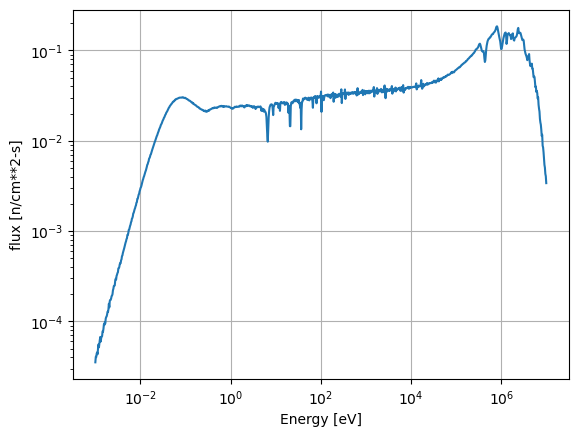

In [18]:
energy_x = 0.5*(energy_bins[0:-1] + energy_bins[1:]);

plt.loglog(energy_x,avg_flux_vals);
plt.grid();
plt.xlabel('Energy [eV]');
plt.ylabel('flux [n/cm**2-s]');

In [19]:
pu238_fiss_t = sp.get_tally(name='Pu238_fiss')
pu238_fiss_df = pu238_fiss_t.get_pandas_dataframe()
pu238_n = pu238_fiss_df['mean'][0]
sp.close()

In [20]:
nSteps = 20; # number of burnup steps
# make arrays to hold reaction rate tally data

np238f = np.zeros([nSteps,],dtype=np.float64);
np237n2n = np.zeros_like(np238f);
pu238f = np.zeros_like(np238f);
pu238c = np.zeros_like(np238f);

name_stub = "openmc_simulation_n";
name_suffix = ".h5"

# populate the arrays
for n in range(nSteps):
    fn = name_stub + str(n) + name_suffix # assemble the filename
    sp = openmc.StatePoint(fn); # open the statepoint file
    
    # read the tallies and populate associated numpy arrays
    t1 = sp.get_tally(name="Np238_fiss");
    t1_df = t1.get_pandas_dataframe()
    np238f[n] = t1_df['mean'][0];
    
    t2 = sp.get_tally(name="Np237_n2n");
    t2_df = t2.get_pandas_dataframe();
    np237n2n[n] = t2_df['mean'][0];
    
    t3 = sp.get_tally(name="Pu238_fiss");
    t3_df = t3.get_pandas_dataframe();
    pu238f[n] = t3_df['mean'][0];
    
    t4 = sp.get_tally(name="Pu238_capture");
    t4_df = t4.get_pandas_dataframe();
    pu238c[n] = t4_df['mean'][0];
    
    sp.close(); # close the statepoint file
    
   

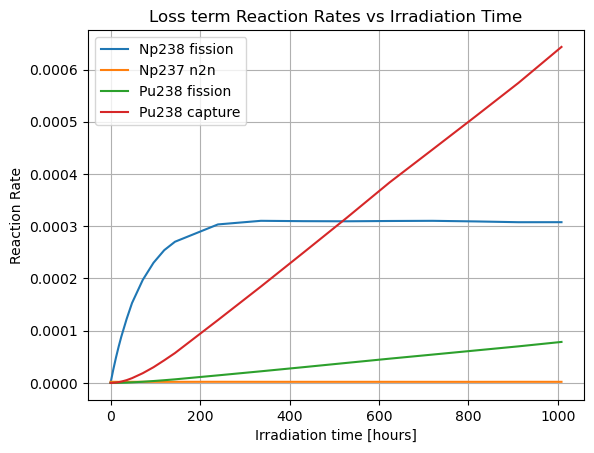

In [21]:
plt.plot(times,np238f,label='Np238 fission')
plt.plot(times,np237n2n,label='Np237 n2n');
plt.plot(times,pu238f,label='Pu238 fission')
plt.plot(times,pu238c, label='Pu238 capture')
plt.grid()
plt.legend()
plt.xlabel('Irradiation time [hours]')
plt.ylabel('Reaction Rate')
plt.title('Loss term Reaction Rates vs Irradiation Time');


In [38]:
r = openmc.deplete.Results("depletion_results.h5")
type(r)

openmc.deplete.results.Results

In [39]:
burned_materials = r.export_to_materials(burnup_index=19)

In [40]:
burned_materials.export_to_xml()

In [41]:
print(burned_materials)

[Material
	ID             =	3
	Name           =	target
	Temperature    =	None
	Density        =	None [sum]
	S(a,b) Tables  
	Nuclides       
	Al27           =	0.042183829047439676 [ao]
	O17            =	3.7812672922465366e-06 [ao]
	Ag107          =	3.9759821032028e-16 [ao]
	Ag109          =	2.8302283738726314e-08 [ao]
	Ag110_m1       =	1.9556982892779e-11 [ao]
	Ag111          =	1.1339024357414133e-09 [ao]
	Am241          =	2.8245536363280364e-13 [ao]
	Am242          =	3.899103113134091e-16 [ao]
	Am242_m1       =	2.6814805769399217e-16 [ao]
	Am243          =	4.782682496301491e-15 [ao]
	Am244          =	1.2545119557723675e-19 [ao]
	Am244_m1       =	8.738276552894063e-20 [ao]
	B10            =	8.440980183952572e-22 [ao]
	B11            =	1.0000199759306173e-21 [ao]
	Ba134          =	5.047115326777937e-12 [ao]
	Ba137          =	2.2386800287997647e-10 [ao]
	Ba140          =	6.54541684442271e-08 [ao]
	Br81           =	3.5167424216007786e-09 [ao]
	Cd110          =	4.209659706231542e-10 [ao]
	

What follows is a bit of a hack-job but, once we have written the newly burned material to an XML file, we can parse the XML file using the xml.etree.ElementTree library, obtain an XML Element object from the XML file for the material of interest, and then use that to construct a Material object.  

I think this *should* be easier to do, but right now I can't figure out a way.

In [44]:
import xml.etree.ElementTree as ET

In [52]:
mat_tree = ET.parse('materials.xml')
#dir(mat_tree)
root = mat_tree.getroot()
for child in root:
    print(child.tag, child.attrib)

material {'depletable': 'true', 'id': '3', 'name': 'target', 'volume': '52.70717853328913'}
material {'depletable': 'true', 'id': '4', 'name': 'UO2', 'volume': '1264.9722847989392'}
material {'id': '5', 'name': 'Zirc-4'}
material {'id': '6', 'name': 'Water'}


In [69]:
i = 0;
for child in root:
    if child.attrib['name']=='target':
        target_elem = root[i];
    if child.attrib['name']=='UO2':
        UO2_elem = root[i];
    i+=1
print(target_elem.attrib)

{'depletable': 'true', 'id': '3', 'name': 'target', 'volume': '52.70717853328913'}


In [70]:
type(target_elem)

xml.etree.ElementTree.Element

I now have a variable of XML Element that, perhaps, I can use to construct a Material object from data in the XML file.

In [71]:
target_mat = openmc.Material.from_xml_element(target_elem)

In [73]:
UO2_mat = openmc.Material.from_xml_element(UO2_elem)

In [75]:
print(target_mat.get_activity(by_nuclide = True)) #provides specific activity by nuclide in Bq/gm

{'Al27': 0.0, 'O17': 0.0, 'Ag107': 0.0, 'Ag109': 0.0, 'Ag110_m1': 628189.6391437354, 'Ag111': 1221043494.2272794, 'Am241': 14.341195954827343, 'Am242': 4686.246930193856, 'Am242_m1': 0.041771204422132086, 'Am243': 0.014253602579004127, 'Am244': 2.3915330723937274, 'Am244_m1': 38.82635740763845, 'B10': 0.0, 'B11': 0.0, 'Ba134': 0.0, 'Ba137': 0.0, 'Ba140': 41176269283.1053, 'Br81': 0.0, 'Cd110': 0.0, 'Cd111': 0.0, 'Cd112': 0.0, 'Cd113': 1.7363374757163705e-09, 'Cd114': 0.0, 'Ce140': 0.0, 'Ce141': 25992459015.242764, 'Ce142': 0.0, 'Ce143': 38317353264.15965, 'Ce144': 3440367980.3806477, 'Cm242': 111.64659073339381, 'Cm243': 0.0009324083908289753, 'Cm244': 0.02611635116769244, 'Cm245': 1.0774548719818509e-07, 'Cm246': 4.885940731584445e-09, 'Cs133': 0.0, 'Cs134': 4821525.183995312, 'Cs135': 798.6231047374432, 'Cs136': 69736499.87514809, 'Cs137': 124876951.79054257, 'Dy160': 0.0, 'Dy161': 0.0, 'Dy162': 0.0, 'Dy163': 0.0, 'Dy164': 0.0, 'Er162': 0.0, 'Er164': 0.0, 'Er166': 0.0, 'Er167': 0.0, 

In [80]:
print('Target material activity is %5.3g Bq/g ' % target_mat.get_activity())

Target material activity is 2.11e+13 Bq/g 


In [81]:
print('UO2 material activity is %5.3g Bq/g ' % UO2_mat.get_activity())

UO2 material activity is 1.47e+13 Bq/g 
